In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.data.all import *
from fastai2.data.core import *
from fastai2.distributed import *
from fastai2.data.transforms import *
import gc
from itertools import product
from scipy import signal
import seaborn as sns

In [3]:
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 300
rcParams['agg.path.chunksize'] = 10000

In [4]:
SEGMENT_SIZE = 500000 
WINDOW_SIZE = 4000
BS = torch.cuda.device_count() * 32
SPLITS = 5
AUGMENT_FLIP = False
XTRA_DS = False

FEAT_WINDOW = 8

assert SEGMENT_SIZE % WINDOW_SIZE == 0
assert (SEGMENT_SIZE // WINDOW_SIZE) % SPLITS == 0
SEED = 321
DATA_SUFFIX = '_clean'

p_input = Path('input')

# Read data

In [5]:
# read data
train_dtypes = {'time': np.float32, 'signal': np.float32, 'open_channels': np.int32 }
test_dtypes  = {'time': np.float32, 'signal': np.float32 }
df_train  = pd.read_csv(p_input / f'train.csv', dtype= train_dtypes)
df_test   = pd.read_csv(p_input / f'test.csv',  dtype= test_dtypes)
df_train_drift = pd.read_csv(p_input / f'train{DATA_SUFFIX}.csv', dtype= train_dtypes)
df_test_drift  = pd.read_csv(p_input / f'test{DATA_SUFFIX}.csv',  dtype= test_dtypes)
sub   = pd.read_csv(p_input / 'sample_submission.csv',  dtype={'time': np.float32})
df_train['drift'] = df_train['signal'] - df_train_drift['signal']
df_test['drift']  = df_test['signal']  - df_test_drift['signal']

In [6]:
df_train['signal'] =  df_train_drift['signal']
df_test['signal']  =   df_test_drift['signal']

In [7]:
#df_train['open_channels'][2300000:2400000][(df_train['open_channels'][2300000:2400000]==0)]=1

In [8]:
d_xtra_csvs = {
    1: ['outfinaltest10.csv',  'outfinaltest44.csv',],#  'outfinaltest78.csv',],  'outfinaltest10.csv',  'outfinaltest44.csv'],
    3: ['outfinaltest1.csv',   'outfinaltest2.csv',   'outfinaltest3.csv',   'outfinaltest4.csv', 'outfinaltest5.csv'],
    5: ['outfinaltest328.csv', 'outfinaltest534.csv', 'outfinaltest747.csv',]#, 'outfinaltest328.csv', 'outfinaltest534.csv']
}

df_train_xtra = None
for _,xtra_csvs in d_xtra_csvs.items():
    for xtra_csv in xtra_csvs:
        xx = pd.read_csv(p_input / xtra_csv , header=None,names=['time', 'signal', 'open_channels'])
        df_train_xtra = pd.concat((xx,df_train_xtra), axis=0)
df_train_xtra['drift']  = 0.
if XTRA_DS: df_train = pd.concat((df_train,df_train_xtra), axis=0)

In [9]:
train = torch.cat((torch.FloatTensor(df_train['signal'        ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['drift'         ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['open_channels' ].values).unsqueeze(0)))
test  = torch.cat((torch.FloatTensor(df_test ['signal'        ].values).unsqueeze(0),
                   torch.FloatTensor(df_test ['drift'         ].values).unsqueeze(0)))

# Synth

In [10]:
p_synth = Path('synth')

use_memmap = True
load_fn = np.load if not use_memmap else partial(np.lib.format.open_memmap, mode='r')
try:
    high = load_fn(str(p_synth / 'high.npy'))
    low  = load_fn(str(p_synth / 'low.npy'))
except:
    high = pd.read_csv(p_synth / 'high.csv',header=None).values.astype('uint8')
    low  = pd.read_csv(p_synth / 'low.csv' ,header=None).values.astype('uint8')
    np.save(str(p_synth / 'high.npy'), high)
    np.save(str(p_synth / 'low.npy'),   low)


# Filter 

In [11]:
fs = 10000
Q = 15
f0 = 50
b, a = signal.iirnotch(f0, Q, fs)
#train[0] = Tensor(signal.filtfilt(b,a,train[0]).copy())
#test[0]  = Tensor(signal.filtfilt(b,a,test[0]).copy())

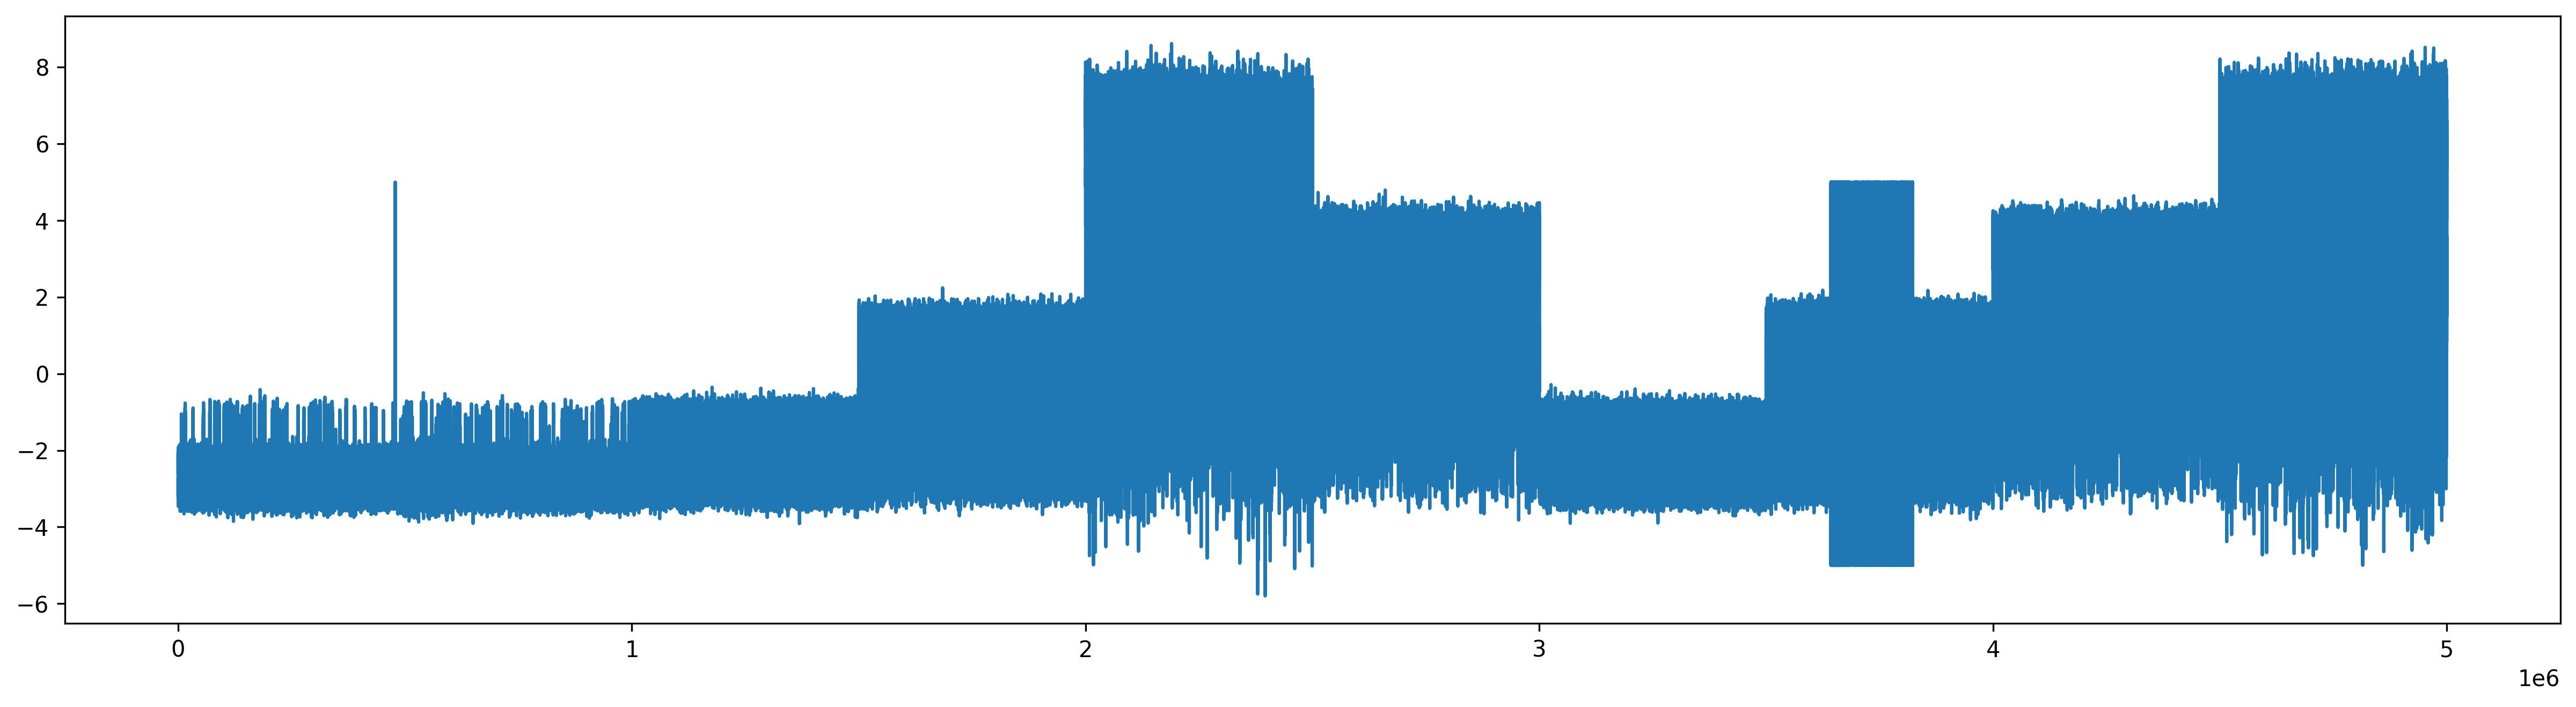

In [12]:
plt.plot(train[0])

In [13]:
train = train.view(train.shape[0],-1,SEGMENT_SIZE)
test  =  test.view( test.shape[0],-1,SEGMENT_SIZE)

# EDA

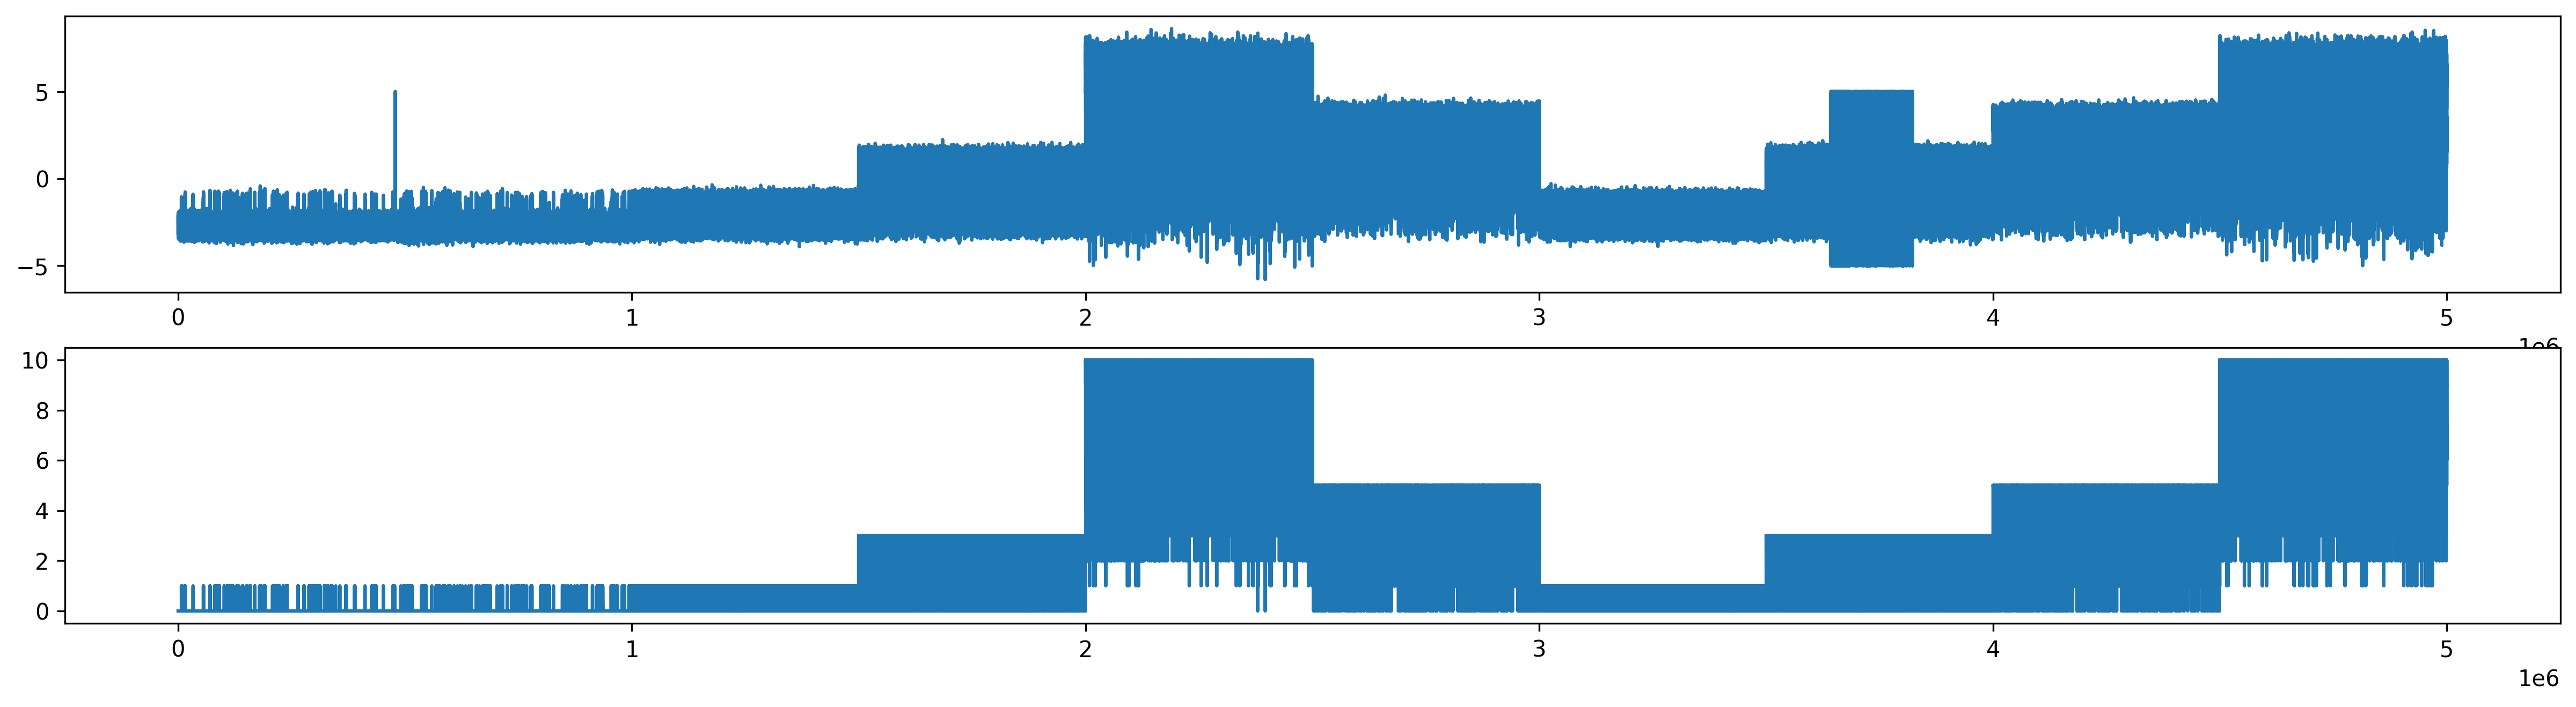

In [14]:
si = train[0,:,:].flatten()#  + train[1,:,:].flatten()
oc = train[2,:,:].flatten()
plt.subplot(2, 1, 1)
plt.plot(si)
plt.subplot(2, 1, 2)
plt.plot(oc)

0.30,0.29,0.29,0.29,0.29,0.29,nan,nan,nan,nan,nan,

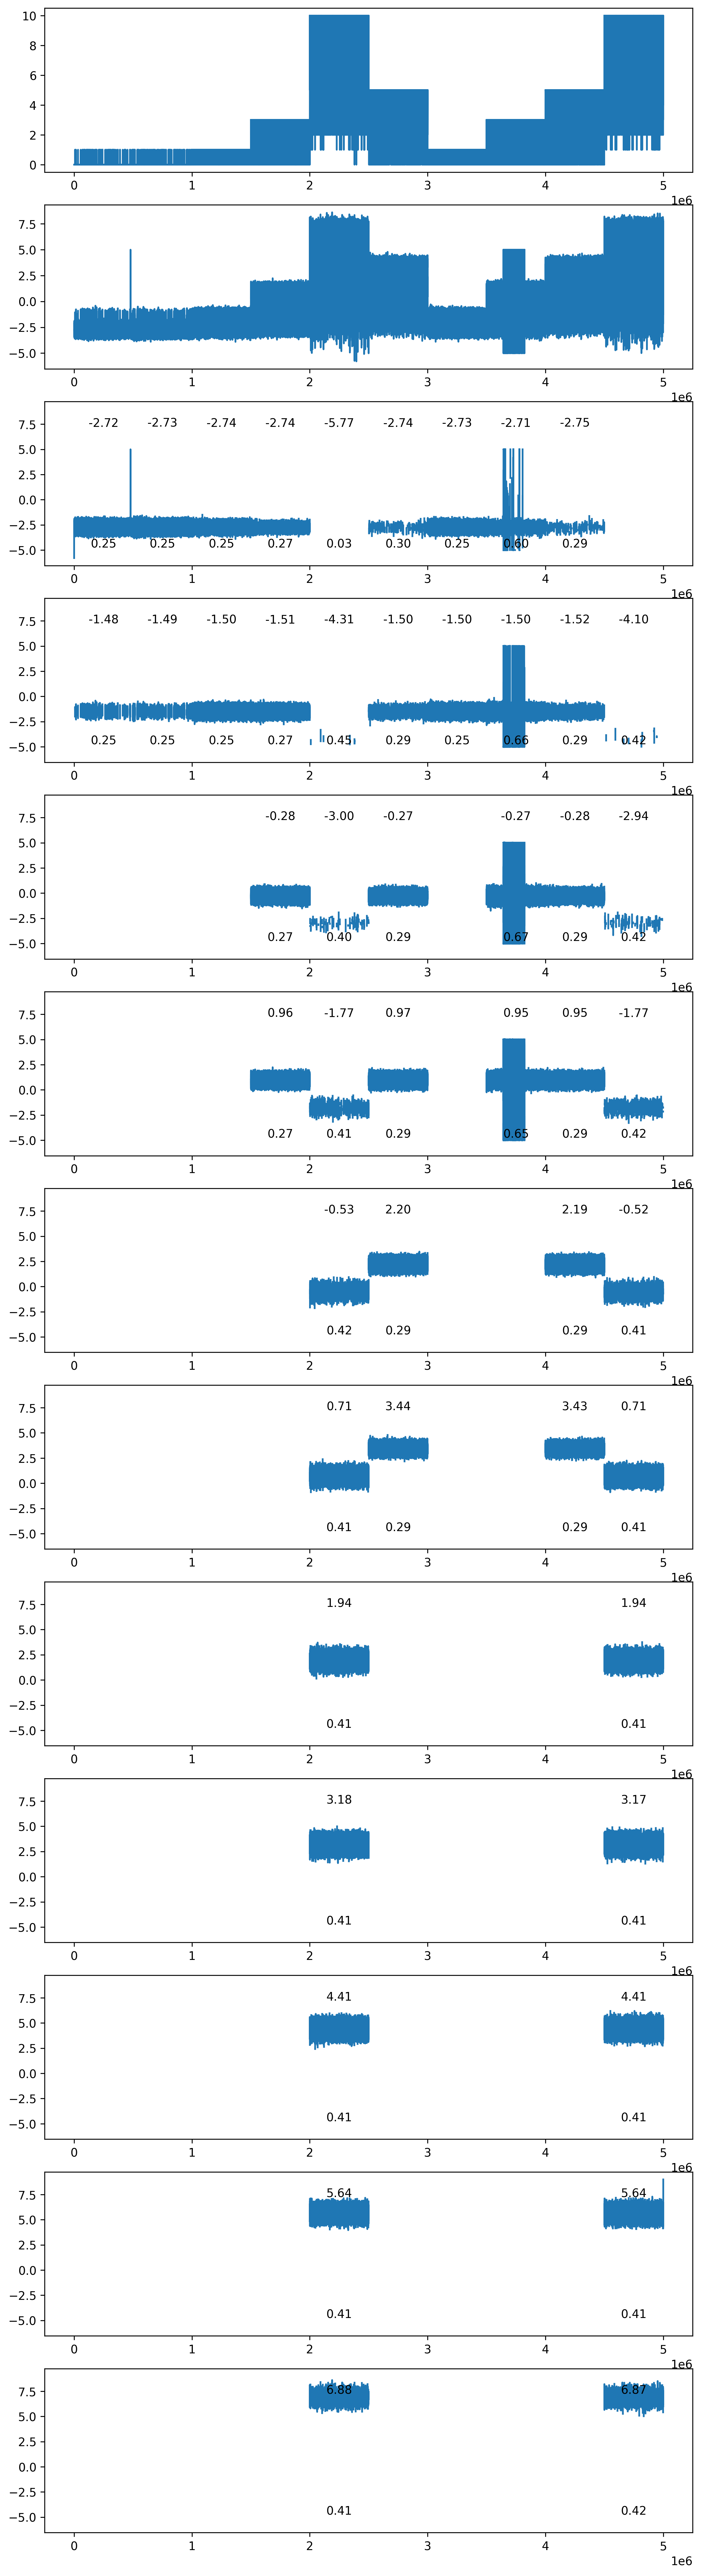

In [15]:
plt.figure(figsize=(10,40))
plt.subplot(13,1,1)
plt.plot(oc)
plt.subplot(13,1,2)
plt.plot(si)
SS = 500000

for i in range(11):
    plt.subplot(13,1,i+3)
    ss = si.clone()
    ss[oc != i] = Tensor([np.nan])
    ss[0] =  si.min()
    ss[-1] = 9
    
    for s in range(10):
        sss = slice(s*SS,(s+1)*SS)
        v = si[sss][oc[sss] == i]
        
        mean,std = v.mean(), v.std()
        
        if ~torch.isnan(mean):
            plt.annotate(f'{mean.item():0.02f}',xy=(SS/2+s*SS, 7), xycoords='data',
                        horizontalalignment='center', verticalalignment='bottom')

        if ~torch.isnan(std):
            plt.annotate(f'{std.item():0.02f}',xy=(SS/2+s*SS, -5), xycoords='data',
                        horizontalalignment='center', verticalalignment='bottom')
        if s==5: print(f"{std.item():0.02f},",end="")
            
    plt.plot(ss)

In [16]:
#sns.distplot(si[:SS])

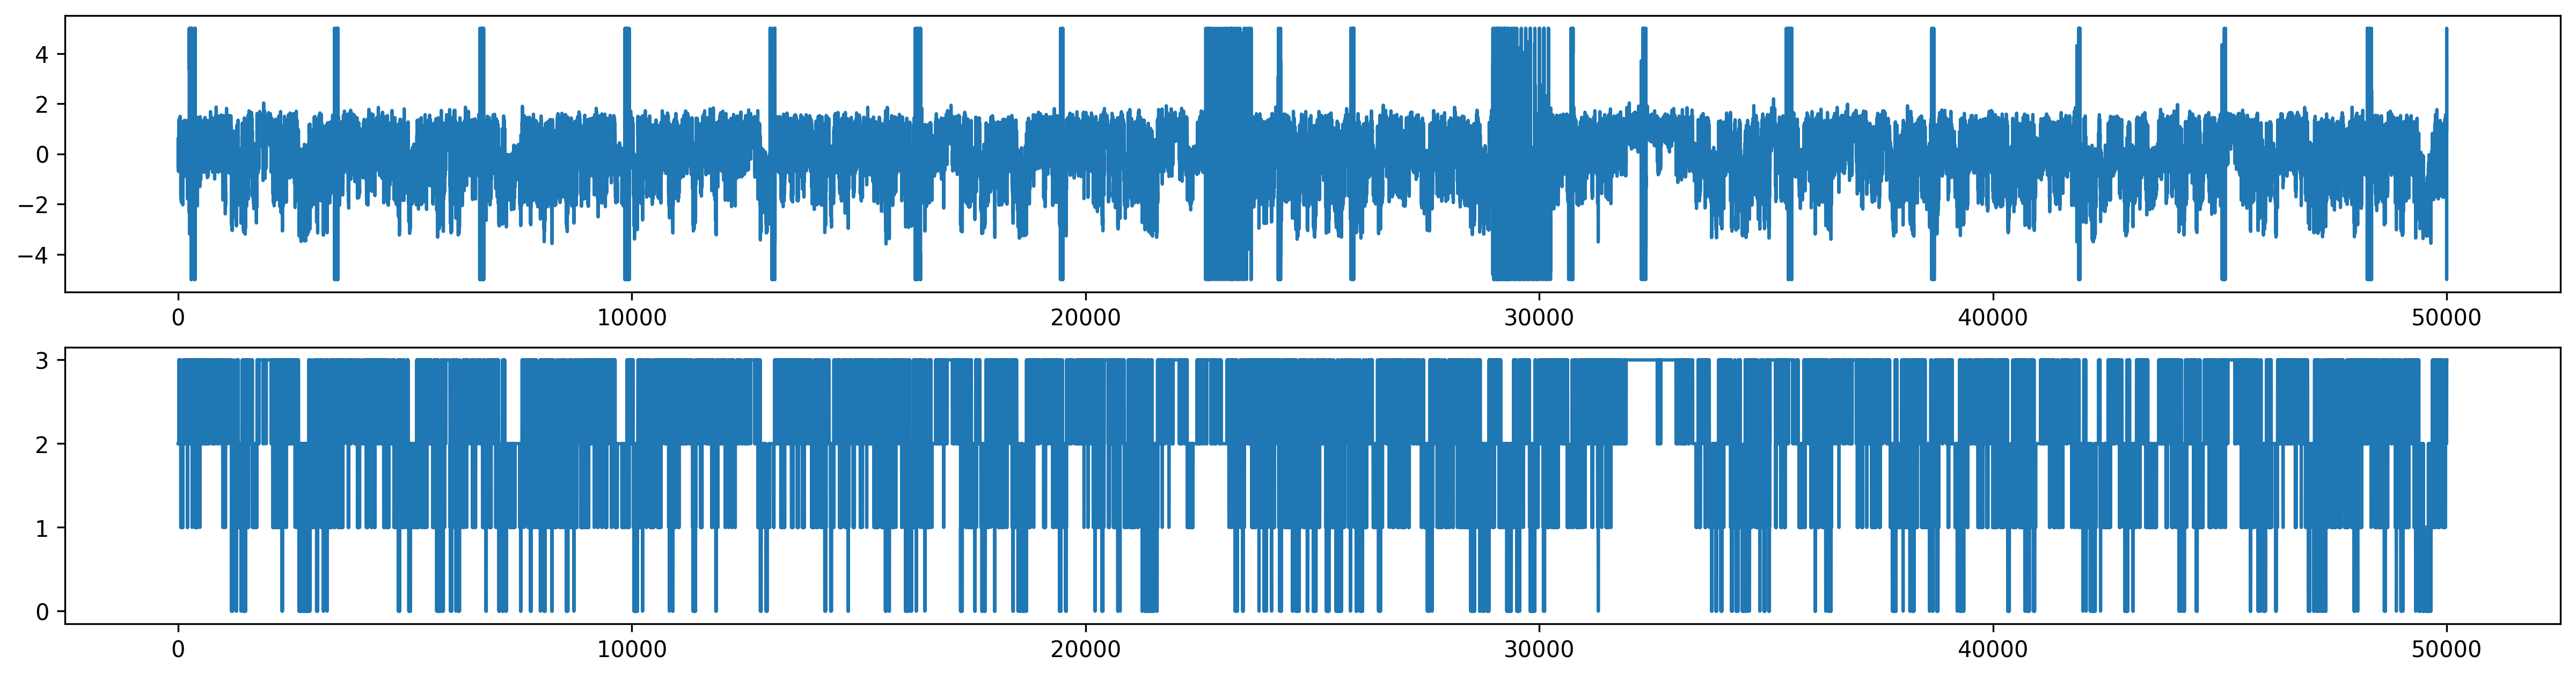

In [17]:
SS = 500000
ss = 7*SS
sss = slice(ss,ss+SS)
plt.subplot(2, 1, 1)
plt.plot(si[sss][250000:300000])
plt.subplot(2, 1, 2)
plt.plot(oc[sss][250000:300000])

# Normalize

In [18]:
signal = torch.cat((train[0],test[0]))
signal_mean, signal_std = signal.mean(),signal.std()
train[0] = (train[0] - signal_mean) / signal_std
test[0]  = ( test[0] - signal_mean) / signal_std


In [19]:
if AUGMENT_FLIP: train = torch.cat((train,train.flip(2)),dim=1)
train.shape

torch.Size([3, 10, 500000])

In [20]:
def build_lag_lead(x,DIM):
    w = DIM
    ws = x.shape[-1]
    r = math.ceil(w/ws) + 1
    x_lead  = x.repeat(1,1,r)[...,:ws+w-1]
    x_lag   = x.repeat(1,1,r).flip((2))[...,:ws+w-1]
    lead,lag=x_lead.unfold(2,w,1), x_lag.unfold(2,w,1).flip((2))
    return torch.cat((lead,lag),dim=3)#.squeeze(1)#.permute(0,2,1)

train = build_lag_lead(train,FEAT_WINDOW)
test  = build_lag_lead(test, FEAT_WINDOW)
train.shape,test.shape

(torch.Size([3, 10, 500000, 16]), torch.Size([2, 4, 500000, 16]))

In [39]:
l_train = train.shape[1]*train.shape[2]
train_channels_in_segment=torch.zeros((l_train//SEGMENT_SIZE,11))
for i,s in enumerate(range(0,l_train,SEGMENT_SIZE)):
    train_channels_in_segment[i] = \
        torch.histc(FloatTensor(df_train['open_channels'][s:s+SEGMENT_SIZE].values),11,0,11)
assert len(train_channels_in_segment)*SEGMENT_SIZE == train.shape[1]*train.shape[2]
totals = train_channels_in_segment.sum(dim=0)
totals[:5].sum(),totals[5:].sum()
train_channels_in_segment

tensor([[4.8413e+05, 1.5866e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.8066e+05, 1.9338e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2600e+05, 3.7400e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.1778e+04, 8.6930e+04, 2.1688e+05, 1.8441e+05, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0000e+00, 5.7000e+01, 5.2600e+02, 3.4260e+03, 1.4625e+04, 4.5145e+04,
         9.2779e+04, 1.3232e+05, 1.2324e+05, 6.9650e+04, 1.8228e+04],
        [9.5600e+02, 1.1732e+04, 5.9234e+04, 1.4733e+05, 1.8758e+05, 9.3163e+04,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2320e+05, 3.7680e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.00

In [22]:
test_channels_in_segment = FloatTensor([
    [1,1,0,0,0,0,0,0,0,0,0], # A
    [1,1,1,1,0,0,0,0,0,0,0], # B
    [0,1,1,1,1,1,0,0,0,0,0], # C
    [1,1,0,0,0,0,0,0,0,0,0], # D
    [1,1,0,0,0,0,0,0,0,0,0], # E
    [0,0,0,0,1,1,1,1,1,1,1], # F
    [1,1,1,1,1,1,0,0,0,0,0], # G
    [0,0,0,0,1,1,1,1,1,1,1], # H
    [1,1,0,0,0,0,0,0,0,0,0], # I
    [1,1,1,1,0,0,0,0,0,0,0], # J
    [1,1,0,0,0,0,0,0,0,0,0], # 
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
])
test_channels_in_segment = test_channels_in_segment.unsqueeze(0).repeat(100000//SEGMENT_SIZE,1,1).transpose(0,1).reshape(-1,11)
#assert test_channels_in_segment.shape[0]*SEGMENT_SIZE == test.shape[1]*test.shape[2]
test_channels_in_segment.shape

torch.Size([0, 11])

# Dataset and splits

In [23]:
split = 0
split_size = SEGMENT_SIZE//WINDOW_SIZE//SPLITS
splits_per_segment = np.arange(SEGMENT_SIZE//WINDOW_SIZE)
valid_split_idx = split*split_size + np.arange(split_size)
all_segments = range(train.shape[1])
valid_idx = list(product(range(50) if XTRA_DS else all_segments,valid_split_idx))
train_idx = list(product(all_segments,splits_per_segment))
train_idx = list(sorted(set(train_idx).difference(set(valid_idx))))

In [24]:
(torch.normal(0,100.,(1000,)) * 1).std()

tensor(100.1360)

In [27]:
means = FloatTensor([-5.49309926, -4.25506493, -3.0170306, -1.77899627,  -0.54096195, 0.69707238,
                     1.93510671,  3.17314104, 4.41117536, 5.64920969, 6.88724402])
stds  = FloatTensor([np.nan,0.42,0.42,0.42,0.41,0.41,0.41,0.41,0.41,0.41,0.42])
y = train[2,9,:100,0].long()
y
print(y.shape)
means[y] + stds[y] * torch.normal(0,1.,(y.numel(),))

torch.Size([100])


tensor([7.0340, 6.3896, 7.2914, 6.1085, 6.9007, 7.6063, 7.4391, 6.5453, 7.1810,
        7.6122, 6.9327, 6.3520, 6.7095, 7.0395, 6.4220, 6.8250, 6.8401, 6.7162,
        6.6058, 6.8748, 7.2422, 6.0511, 7.0885, 6.6074, 7.1921, 6.7750, 7.0410,
        6.5037, 6.1099, 7.4525, 7.1933, 7.3928, 6.9127, 6.7139, 7.0894, 7.9814,
        6.3857, 7.2596, 7.0967, 6.4024, 7.1177, 7.3588, 7.0374, 6.8107, 6.6136,
        6.5276, 6.9916, 6.8314, 6.9409, 7.1696, 7.2328, 6.7206, 7.3052, 6.6454,
        7.1001, 6.7796, 6.5027, 6.7094, 6.7117, 7.9726, 7.2676, 6.5596, 6.1608,
        7.2452, 6.9206, 6.7934, 6.0010, 7.0212, 6.7514, 7.1313, 6.4989, 6.9839,
        6.4461, 6.8214, 6.9708, 6.8416, 6.9355, 5.4687, 6.1440, 6.9037, 7.4513,
        7.3297, 7.1421, 7.3092, 7.3782, 5.6761, 7.0221, 7.3577, 5.8772, 5.8898,
        5.1377, 6.0069, 6.8783, 6.9161, 7.3040, 7.6044, 7.2994, 7.2529, 7.3644,
        7.3311])

In [66]:
class IonDataset(torch.utils.data.Dataset):
    def __init__(self, data,idx=None,jitter=False,p_flip=0.,balance=False,synth=False):
        super().__init__()
        self.data, self.channels_in_segment,self.jitter,self.p_flip,self.synth = *data, jitter, p_flip,synth
        self.idx = ifnone(idx,list(product(range(self.data.shape[1]),np.arange(SEGMENT_SIZE//WINDOW_SIZE))))
        self.n_inp = 1
        self.has_y = self.data.shape[0] == 3
        self.hist = torch.zeros((11,))
    def __len__(self): return len(self.idx)
    def __getitem__(self, idx):
        s,o=self.idx[idx]
        jitter = 0
        if self.jitter:
            os,oe = 0,0
            if (s,(o-1)) in self.idx: os = -WINDOW_SIZE//2
            if (s,(o+1)) in self.idx: oe =  WINDOW_SIZE//2
            jitter = torch.randint(os,oe,(1,)).item()
        ss = slice(jitter+o*WINDOW_SIZE,jitter+(o+1)*WINDOW_SIZE)
        x =  self.data[0,s,ss,:]
        segment = self.data[0,s,:1,0]
        flip = (torch.rand(1) < self.p_flip).item()
        if flip: x,segment = torch.flip(x,dims=(1,)), torch.flip(segment,dims=(0,))
        if self.has_y: 
            y_drift,y_open_channels = (self.data[1,s:s+1,ss,0], self.data[2,s:s+1,ss,0].long())
            if flip: y_drift,y_open_channels=(torch.flip(y_drift,dims=(1,)),torch.flip(y_open_channels,dims=(1,)))

        if self.synth and self.has_y:
            if self.channels_in_segment[s][-1] > 0:
                means = FloatTensor([-5.49309926, -4.25506493, -3.0170306, -1.77899627,  -0.54096195, 0.69707238,
                                     1.93510671,  3.17314104, 4.41117536, 5.64920969, 6.88724402])
                stds  = FloatTensor([0.42,0.42,0.42,0.42,0.41,0.41,0.41,0.41,0.41,0.41,0.42])
            else:
                means = FloatTensor([-2.73135856, -1.49979538, -0.26823219, 0.963331,   2.19489419, 3.42645737,
                                    np.nan,        np.nan,    np.nan,     np.nan,     np.nan])
                stds  = FloatTensor([0.30,0.29,0.29,0.29,0.29,0.29,np.nan,np.nan,np.nan,np.nan,np.nan])
            x = means[y_open_channels] + stds[y_open_channels] * torch.normal(0,1.,(y_open_channels.numel(),))
            x = (x - signal_mean) / signal_std
            x = build_lag_lead(x,FEAT_WINDOW).squeeze(0).squeeze(0)
        x = (x,segment) 
        return (x,y_open_channels) if self.has_y else (x,)

    
train_ds = IonDataset((train, train_channels_in_segment), train_idx, jitter=True, synth=True)
valid_ds = IonDataset((train, train_channels_in_segment), valid_idx)
test_ds  = IonDataset((test,  test_channels_in_segment))
train_ds[0][0][0].shape

torch.Size([4000, 16])

In [67]:
train_dl = DataLoader(train_ds, BS,    shuffle=True,  num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, BS,    shuffle=False, num_workers=8, pin_memory=True)
test_dl  = DataLoader(test_ds,  BS//2, shuffle=False, num_workers=8, pin_memory=True)
test_ds[2],test_ds[2][0][1].shape

(((tensor([[-0.9221, -1.0072, -0.9750,  ..., -0.8773, -0.8816, -0.9820],
           [-1.0072, -0.9750, -1.1598,  ..., -1.0268, -0.8773, -0.8816],
           [-0.9750, -1.1598, -0.8980,  ..., -0.8998, -1.0268, -0.8773],
           ...,
           [-1.0178, -0.8282, -0.9176,  ..., -1.0394, -1.0853, -0.8658],
           [-0.8282, -0.9176, -0.7654,  ..., -1.0942, -1.0394, -1.0853],
           [-0.9176, -0.7654, -0.9677,  ..., -0.9319, -1.0942, -1.0394]]),
   tensor([-0.9362])),),
 torch.Size([1]))

# Model 

In [68]:
# wavenet 
# from https://www.kaggle.com/hanjoonchoe/wavenet-lstm-pytorch-ignite-ver
class Wave_Block(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates, kernel_size):
        super(Wave_Block, self).__init__()
        self.num_rates = dilation_rates
        self.convs = nn.ModuleList()
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()

        self.convs.append(nn.Conv1d(in_channels, out_channels, kernel_size=1))
        dilation_rates = [2 ** i for i in range(dilation_rates)]
        for dilation_rate in dilation_rates:
            self.filter_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, 
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.gate_convs.append(
                nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, 
                          padding=int((dilation_rate*(kernel_size-1))/2), dilation=dilation_rate))
            self.convs.append(nn.Conv1d(out_channels, out_channels, kernel_size=1))

    def forward(self, x):
        x = self.convs[0](x)
        res = x
        for i in range(self.num_rates):
            x = torch.tanh(self.filter_convs[i](x)) * torch.sigmoid(self.gate_convs[i](x))
            x = self.convs[i + 1](x)
            res = res + x
        return res
# detail 
class Classifier(nn.Module):
    def __init__(self, inch=FEAT_WINDOW*2, kernel_size=15):
        super().__init__()
        f_d = [(inch,12), (inch*2,8), (inch*4,4), (inch*8,1), (inch*16,)]
        self.wave_blocks = []
        for i in range(len(f_d)-1):
            f_in, f_out = f_d[i][0], f_d[i+1][0]
            self.wave_blocks.append(Wave_Block(f_in, f_out,f_d[i][1],kernel_size))
            self.wave_blocks.append(nn.BatchNorm1d(f_out))
        self.wave_blocks = nn.Sequential(*self.wave_blocks)
        self.LSTM = nn.GRU(input_size=f_out, hidden_size=f_out, num_layers=2, batch_first=True, bidirectional=True, 
                           dropout=0.)
        self.fc = nn.Linear(f_out*2, 11)

    def forward(self, x):
        x,_ = x
        x = x.permute(0, 2, 1)
        x = self.wave_blocks(x)
        x = x.permute(0, 2, 1)
        x, _ = self.LSTM(x)
        return self.fc(x),x

In [69]:
dls = DataLoaders(train_dl, valid_dl, test_dl, device=default_device())

model = ReformerLM(
    num_tokens = 11,
    dim = dim,
    depth = depth,
    max_seq_len = WINDOW_SIZE,
    heads = heads,
    lsh_dropout = lsh_dropout,
    bucket_size=bucket_size,
    causal = False,
    use_full_attn = False,
    fixed_position_emb = False,
    n_hashes = 4,
)
model.token_emb = nn.Linear(1,dim)

In [70]:
model = Classifier()
model

Classifier(
  (wave_blocks): Sequential(
    (0): Wave_Block(
      (convs): ModuleList(
        (0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        (1): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (2): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (4): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (5): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (6): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (7): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (8): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (9): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (10): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (11): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        (12): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      )
      (filter_convs): ModuleList(
        (0): Conv1d(32, 32, kernel_size=(15,), stride=(1,), padding=(7,))
        (1): Conv1d(32, 3

# Loss 

In [71]:
def softf1_loss(logits,true,eps=0,weights=None):
    # 96 4000 11, 96 4000 1 
    n_classes = logits.shape[-1]
    weights = ifnone(weights,torch.ones((n_classes,),dtype=logits.dtype,device=logits.device))
    y_pred = logits.view(-1,n_classes).softmax(dim=-1)             
    y_true = F.one_hot(true.flatten(), n_classes).to(torch.float32)

    tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

    precision = tp / (tp + fp + eps )
    recall = tp / (tp + fn + eps )

    f1 = 2* (precision*recall) / (precision + recall + eps)
    f1 = f1.clamp(0,1) * weights
    f1 = f1[~torch.isnan(f1)].mean()
    return 1-f1

class SoftF1Loss(Module):
    def __init__(self, weight=None): self.weight = weight
    def forward(self, output, target): return softf1_loss(output, target, self.weight)

class LabelSmoothingCE(Module):
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        output = output.permute(0,2,1) # => B C S
        target = target.squeeze(1)     # => B S
        log_preds = F.log_softmax(output, dim=1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

class DriftChannelsLoss(Module):
    def __init__(self, losses, weights=None):
        self.losses, self.weights = losses, ifnone(weights, [1.] * len(losses))
        self.hist = torch.ones((11,))
    def __call__(self, input:Tensor, target:Tensor, **kwargs):
        i_open_channels,_ = input
        t_open_channels   = target
        self.hist = self.hist.to(device=t_open_channels.device) + t_open_channels.flatten().float().histc(11,0,11)
        weight = self.hist.sum() / self.hist
        return L([l(weight=None)(i_open_channels,t_open_channels)*w for l,w in zip(self.losses, self.weights)]).sum()

# Metrics

In [72]:
import sklearn.metrics as skm

# Cell
class OpenChannelsAccumMetric(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, func, dim_argmax=None, sigmoid=False, thresh=None, to_np=False, invert_arg=False,
                 flatten=True, metric_name=None, **kwargs):
        store_attr(self,'func,dim_argmax,sigmoid,thresh,flatten,metric_name')
        self.to_np,self.invert_args,self.kwargs = to_np,invert_arg,kwargs

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        t,p = learn.y,learn.pred[0] #learn.y[1],learn.pred[1]
        pred = p.argmax(dim=self.dim_argmax) if self.dim_argmax else p
        if self.sigmoid: pred = torch.sigmoid(pred)
        if self.thresh:  pred = (pred >= self.thresh)
        #pred = p.round()
        targ = t
        pred,targ = to_detach(pred),to_detach(targ)
        if self.flatten: pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        if self.to_np: preds,targs = preds.numpy(),targs.numpy()
        return self.func(targs, preds, **self.kwargs) if self.invert_args else self.func(preds, targs, **self.kwargs)

    @property
    def name(self):
        return ifnone(self.metric_name,self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__)

# Cell
def skm_to__open_channels_fastai(func, is_class=True, thresh=None, axis=-1, sigmoid=None, **kwargs):
    "Convert `func` from sklearn.metrics to a fastai metric"
    dim_argmax = axis if is_class and thresh is None else None
    sigmoid = sigmoid if sigmoid is not None else (is_class and thresh is not None)
    return OpenChannelsAccumMetric(func, dim_argmax=dim_argmax, sigmoid=sigmoid, thresh=thresh,
                       to_np=True, invert_arg=True, **kwargs)

def MF1Score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None, **kwargs):
    "F1 score for single-label classification problems"
    return skm_to__open_channels_fastai(skm.f1_score, axis=axis,
                         labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight, **kwargs)

def A(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = inp[0],targ#inp[1], targ[1]
    pred,targ = flatten_check(pred.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [73]:
mets = [MF1Score(labels=[l],average='macro', metric_name=f"f1_{l}") for l in range(11)]
mets.extend([MF1Score(labels=list(range(11)),average='macro', metric_name=f"f1"), A])

# Train

In [74]:
learn = None
gc.collect()
torch.cuda.empty_cache()
learn = Learner(dls,model,loss_func=DriftChannelsLoss([CrossEntropyLossFlat]),opt_func=Adam,
                metrics=mets)

#learn.callbacks.extend([F1Metric(learn)])

learn.to_parallel().to_fp16()
summary = learn.summary()
match = re.search(r'Total trainable params: ([0-9,]+)', summary)
model_params = int(match.group(1).replace(",",""))
print(summary)

Classifier (Input shape: ["['64 x 4000 x 16', '64 x 1']"])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 32 x 4000       544        True      
________________________________________________________________
Conv1d               64 x 32 x 4000       1,056      True      
________________________________________________________________
Conv1d               64 x 32 x 4000       1,056      True      
________________________________________________________________
Conv1d               64 x 32 x 4000       1,056      True      
________________________________________________________________
Conv1d               64 x 32 x 4000       1,056      True      
________________________________________________________________
Conv1d               64 x 32 x 4000       1,056      True      
________________________________________________________________
Conv1d               64 x 32 x 4000       1,056      True      
_______________________________________

In [75]:
modelname = None # 'wavenet7487787_t1000_v250_BS96_SS100000_WS4000_cv0.9398_clean'
try:
    learn.load(modelname, strict=False)
    print(f"Loaded {modelname}")
except:
    print(f"Failed to load {modelname}")

Failed to load None


In [76]:
#lr_min, lr_steep=learn.lr_find()

In [77]:
#learn.fit_flat_cos(100,lr=1e-3)

In [78]:
learn.fit_one_cycle(100,lr_max=1e-2)#,pct_start=0.5)

epoch,train_loss,valid_loss,f1_0,f1_1,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f1_9,f1_10,f1,A,time
0,1.768752,1.124325,0.933601,0.825063,0.532997,0.477621,0.332034,0.000000,0.000451,0.002554,0.313659,0.000000,0.000000,0.310726,0.584966,00:34
1,1.315267,1.056351,0.891161,0.832818,0.704986,0.707624,0.380849,0.000000,0.002883,0.000035,0.000000,0.000000,0.000000,0.320032,0.628061,00:28
2,1.088715,0.697213,0.954680,0.871281,0.684363,0.768403,0.586863,0.112221,0.428108,0.485440,0.545734,0.348099,0.000000,0.525927,0.733281,00:28
3,0.901538,0.455143,0.977807,0.946860,0.876327,0.897209,0.845883,0.678179,0.563545,0.525917,0.499630,0.623252,0.000000,0.675873,0.845821,00:29
4,0.730900,0.312608,0.957509,0.924332,0.944876,0.957054,0.886473,0.810341,0.797897,0.790609,0.714775,0.696588,0.000000,0.770950,0.897474,00:28
5,0.574212,0.297273,0.975480,0.955385,0.932399,0.922846,0.839598,0.748132,0.581769,0.721776,0.809129,0.784554,0.101486,0.761141,0.893408,00:29
6,0.508864,0.727862,0.340733,0.657633,0.925413,0.877112,0.701222,0.775383,0.792784,0.829857,0.858284,0.837394,0.599852,0.745061,0.709793,00:28
7,0.427134,0.235602,0.973045,0.950144,0.893074,0.896272,0.891297,0.860664,0.865924,0.868299,0.856493,0.726680,0.112976,0.808625,0.911913,00:29
8,0.351908,0.123694,0.996641,0.988769,0.971693,0.966393,0.934149,0.916332,0.870043,0.879469,0.871315,0.859027,0.746377,0.909110,0.956428,00:29
9,0.293584,0.169707,0.995254,0.974926,0.953067,0.965279,0.914782,0.893022,0.795981,0.818814,0.805444,0.763177,0.745886,0.875057,0.935916,00:28


In [ ]:
learn.opt_func=SGD
learn.loss_func=DriftChannelsLoss([CrossEntropyLossFlat, SoftF1Loss], [0.,10.])
learn.fit_flat_cos(100,1e-2)#,pct_start=0.5)

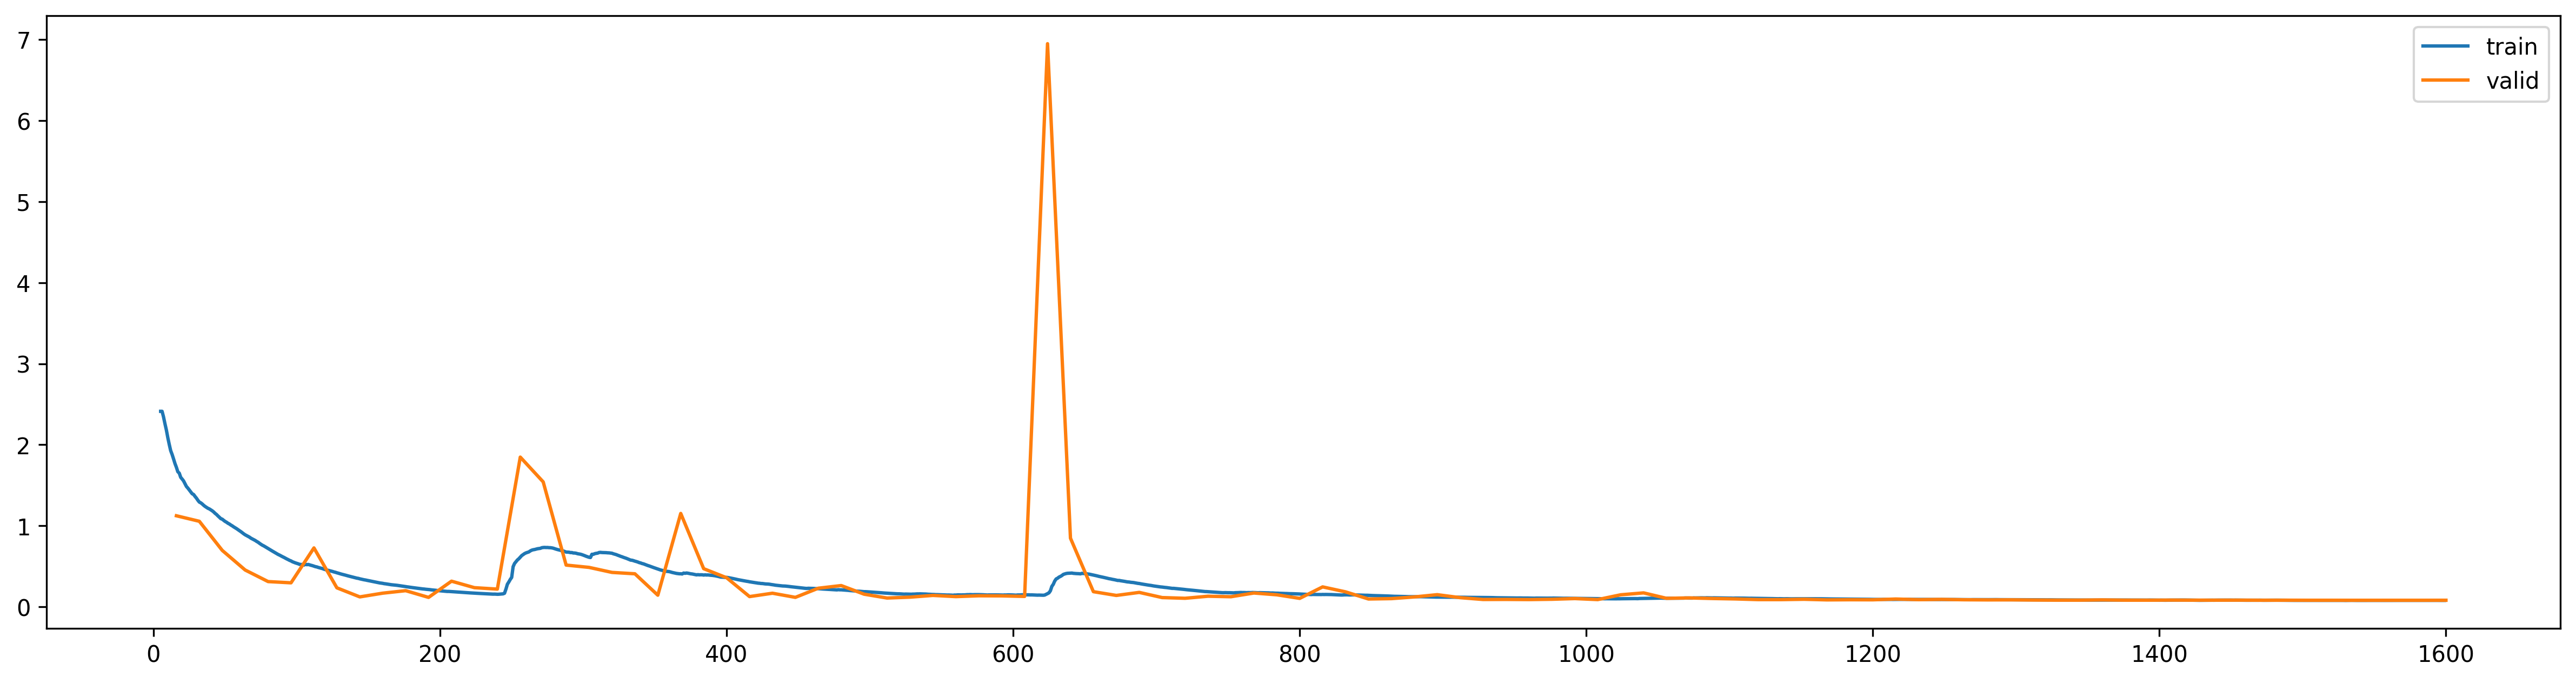

In [79]:
learn.recorder.plot_loss()

In [80]:
cv,_,time = learn.recorder.log[-3:];cv,_,time

(0.9364496961259868, 0.9684751033782959, '00:28')

In [82]:
suffix = '_synth'

In [83]:
modelname = f'wavenet{model_params}_t{len(train_ds)}_v{len(valid_ds)}_BS{BS}_SS{SEGMENT_SIZE}_WS{WINDOW_SIZE}_cv{cv:0.04f}{DATA_SUFFIX}{suffix}'
learn.save(modelname);modelname

'wavenet7487787_t1000_v250_BS64_SS500000_WS4000_cv0.9364_clean_synth'

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_preds, valid_preds = learn.get_preds(0), learn.get_preds(1)
train_preds = train_preds[0][1],train_preds[1]
valid_preds = valid_preds[0][1],valid_preds[1]

In [ ]:
d_feats = train_preds[0].shape[-1]

In [ ]:
x0 = np.hstack((learn.model.fc._parameters['weight'].t().cpu().detach().numpy().flatten(),
                learn.model.fc._parameters['bias'].cpu().detach().numpy().flatten()))
x0.shape

In [ ]:
x0.shape

In [ ]:
#x,y = train_preds[0].view(-1,d_feats).cuda(),train_preds[1].view(-1).cuda()
x = y = None
gc.collect()
torch.cuda.empty_cache()
#x,y = valid_preds[0].view(-1,d_feats).cuda(),valid_preds[1].view(-1).cuda()
x,y = train_preds[0].view(-1,d_feats).cuda(),train_preds[1].view(-1).cuda()


In [ ]:
true   = y
evals = 0
max_evals = len(x0) 
print(max_evals)
imb = master_bar(range(max_evals), total=max_evals)
def adjust_thresholds(thresholds):
    global evals,imb
    m = Tensor(thresholds[:11*d_feats]).view(d_feats,11).cuda()
    b = Tensor(thresholds[11*d_feats:]).view(1,11).cuda()
    preds = (x @ m + b).argmax(dim=-1)
    
    y_pred = F.one_hot(preds,11)                    # S, C
    y_true = F.one_hot(true, 11).to(torch.float32)  # S, C
    
    tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

    precision = tp / (tp + fp )
    recall = tp / (tp + fn )

    f1 = 2* (precision*recall) / (precision + recall)
    f1 = f1.mean().cpu().numpy()

    if evals % 1000 == 0: print(f'{100*evals/max_evals:0.02f}% {f1:0.06f}')#, thresholds)
    evals += 1
    return 1-f1
    
def callback(xk):
    print(evals)
    return False if evals > max_evals else True

res = scipy.optimize.minimize(adjust_thresholds, x0,method='Powell', 
                              options={'disp':True, 'maxfev' : max_evals },
                              callback= callback)

In [ ]:
res.x

In [ ]:
x0 = res.x

In [ ]:
learn.model.fc._parameters['weight']

In [ ]:
learn.model.fc._parameters['weight'].data = Tensor(res.x[:11*d_feats]).view(d_feats,11).t().cuda()
learn.model.fc._parameters['bias'].data   = Tensor(res.x[11*d_feats:]).cuda()

In [ ]:
learn.model.fc._parameters['weight'],learn.model.fc._parameters['bias']

In [ ]:
class F1Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.d = data[0].shape[-1]
        self.x,self.y = data[0].view(-1,self.d),data[1].view(-1)
        self.n_inp = 1
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx].unsqueeze(1),self.y[idx]#.unsqueeze(-1)
    
f1_train_ds,f1_valid_ds = F1Dataset(train_preds), F1Dataset(valid_preds)
f1_train_dl = DataLoader(f1_train_ds, len(f1_train_ds)//100, shuffle=True,   num_workers=8, pin_memory=True)
f1_valid_dl = DataLoader(f1_valid_ds, len(f1_train_ds)//100, shuffle=False,  num_workers=8, pin_memory=True)

In [ ]:
d_feats = train_preds[0].shape[-1]

In [ ]:
f1model = nn.Sequential(nn.Conv1d(d_feats   , d_feats//2,3,1,1,groups=1), nn.ReLU(), 
                        nn.Conv1d(d_feats//2, d_feats//4,3,1,1,groups=1), nn.ReLU(), 
                        nn.Conv1d(d_feats//4 ,        11,3,1,1,groups=1),
                        Flatten())

In [ ]:
f1learn = None
gc.collect()
torch.cuda.empty_cache()
f1learn = Learner(DataLoaders(f1_train_dl,f1_valid_dl, device=default_device()),f1model,
                  loss_func=CrossEntropyLossFlat(),opt_func=Adam,
                  metrics=[F1Score(labels=list(range(11)),average='macro'), accuracy])
f1learn.summary()

In [ ]:
f1learn.fit(1,1e-3)

In [ ]:
f1learn.loss_func = softf1_loss

In [ ]:
f1learn.fit_one_cycle(20,5e-3)

In [ ]:
learn.model=learn.model.module

In [ ]:
learn.model

# Test

In [85]:
learn.model.eval()
test_preds = torch.zeros(len(test_ds)*test_ds[0][0][0].shape[0],11,dtype=torch.float)
n_tta = 0
learn.model = nn.DataParallel(learn.model)
with torch.no_grad():
    for flip in [False]:
        s = 0
        for xx in progress_bar(test_dl):
            x = xx[0]
            if flip: x[0],x[1] = torch.flip(x[0], dims=(2,)),torch.flip(x[1], dims=(1,))
            x = x[0].cuda(), x[1].cuda()
            preds = learn.model(x)
            open_channels,_ = preds
            if flip: open_channels = torch.flip(open_channels, dims=(1,))
            open_channels = open_channels.view(-1,11)
            l = open_channels.shape[0]
            test_preds[s:s+l] += open_channels.cpu()
            s += l
        n_tta +=1
learn.model = learn.model.module

In [86]:
test_preds

tensor([[14.2577,  1.0577,  1.2745,  ..., -7.9612, -8.2839, -7.1653],
        [14.3892,  1.6387,  1.4522,  ..., -8.6286, -8.6888, -7.5505],
        [14.2960,  1.7947,  1.5423,  ..., -8.6553, -8.6766, -7.5920],
        ...,
        [14.2493,  1.8620,  1.6367,  ..., -9.0332, -8.6940, -7.4972],
        [14.2291,  1.8685,  1.5768,  ..., -9.0163, -8.6749, -7.4398],
        [13.9677,  1.8059,  1.5760,  ..., -8.9470, -8.5637, -7.2560]])

In [87]:
open_channels = test_preds.argmax(dim=1)
open_channels.shape

torch.Size([2000000])

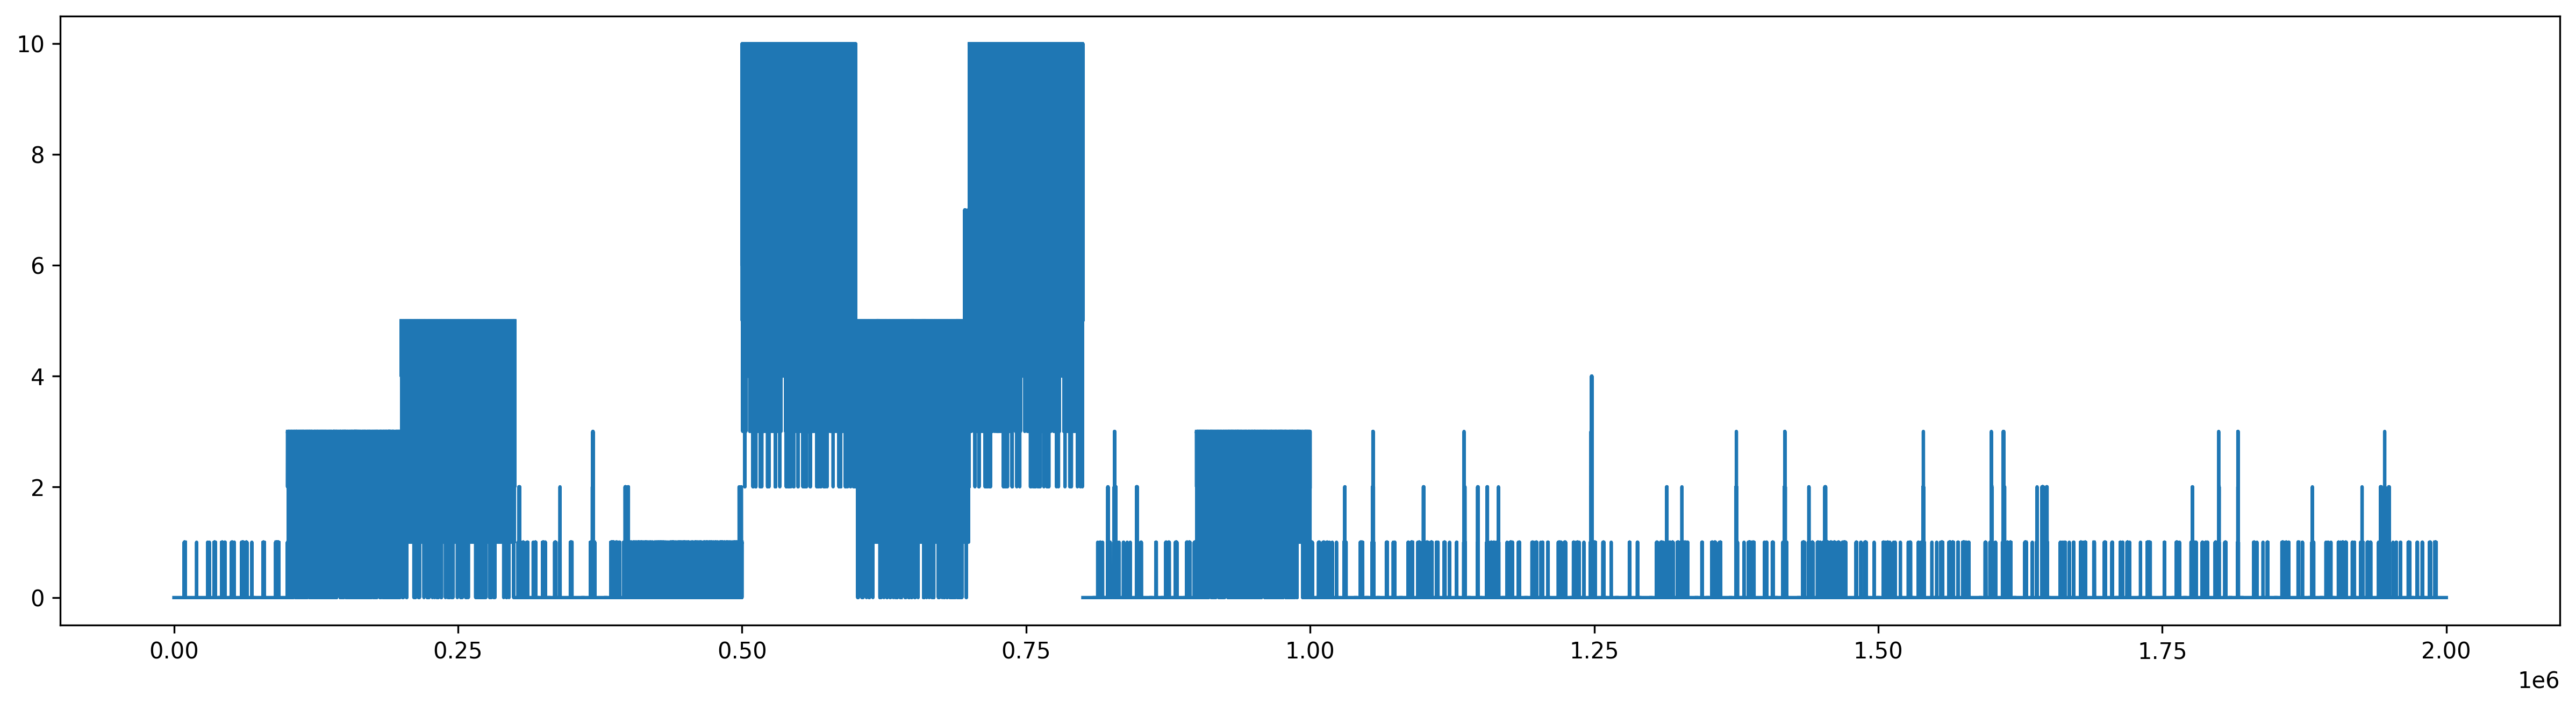

In [88]:
plt.plot(open_channels)

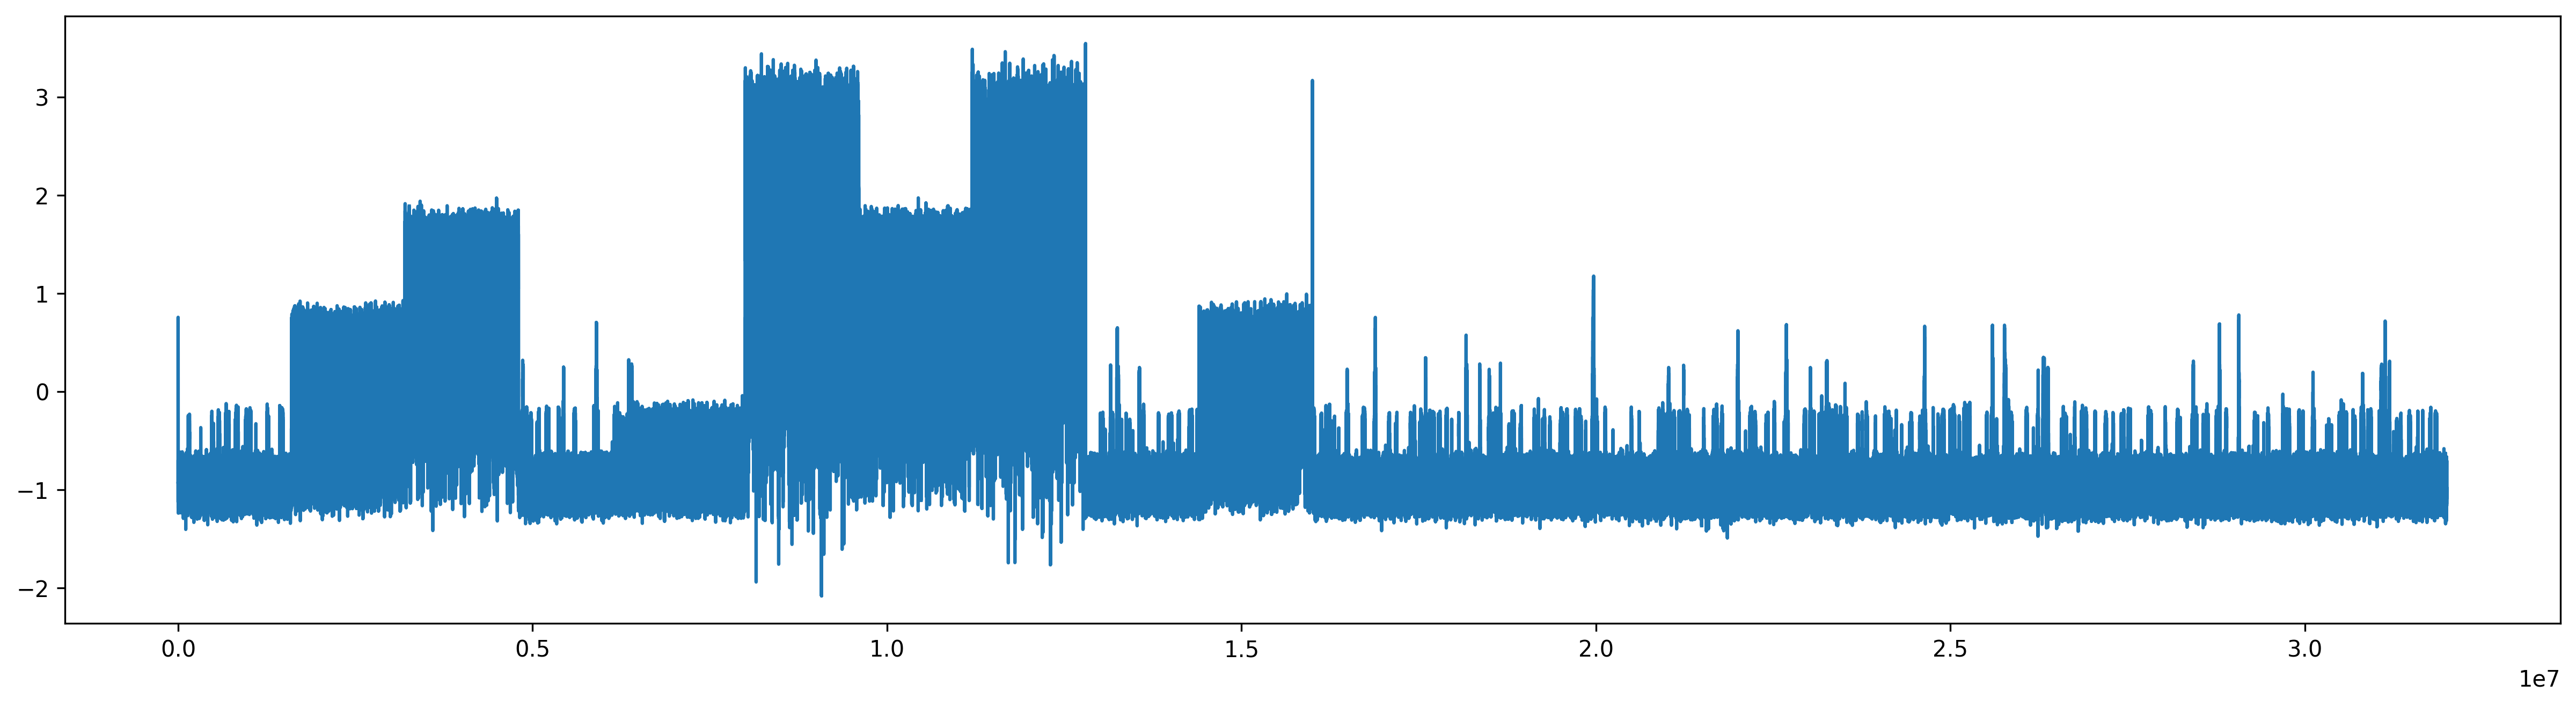

In [89]:
plt.plot(test[0].flatten())

In [90]:
csv_fname = f'{modelname}_n_tta{n_tta}.csv';csv_fname

'wavenet7487787_t1000_v250_BS64_SS500000_WS4000_cv0.9364_clean_synth_n_tta1.csv'

In [91]:
submission_csv_path = p_input / 'sample_submission.csv'
ss = pd.read_csv(submission_csv_path, dtype={'time': str})
test_preds_all = test_preds
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str), 'open_channels': open_channels})
test_pred_frame.to_csv(csv_fname, index=False)

In [92]:
!kaggle competitions submit -c 'liverpool-ion-switching' -f {csv_fname} -m 'xtra {XTRA_DS}'

100%|██████████████████████████████████████| 21.0M/21.0M [00:05<00:00, 4.00MB/s]
Successfully submitted to University of Liverpool - Ion Switching